In [75]:
import pandas as pd
import geopandas as gpd
fire = gpd.read_file("./data_2024/hotspots/fire_archive_M-C61_629919.shp")
cc = gpd.read_file("./data_2024/perimeter/cc_apt_buf.shp")

print(fire.head(3))
print(cc.head(3))


   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME SATELLITE  \
0   56.1487  -119.4577       318.9   1.6    1.2 2024-01-01     2139      Aqua   
1   52.5329  -112.4523       301.5   1.0    1.0 2024-01-02     2041      Aqua   
2   52.2269  -112.6734       307.6   1.0    1.0 2024-01-02     2041      Aqua   

  INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      MODIS          53   61.03       266.8  45.0        D     0   
1      MODIS          48   61.03       269.5  10.3        D     0   
2      MODIS          62   61.03       270.3  14.0        D     0   

                    geometry  
0  POINT (-119.4577 56.1487)  
1  POINT (-112.4523 52.5329)  
2  POINT (-112.6734 52.2269)  
        UID  HCOUNT     AREA            FIRSTDATE             LASTDATE  \
0  32269292      47  112.454  2024-07-11 19:28:00  2024-07-24 10:32:00   
1  32269069     104  710.313  2024-07-14 20:12:00  2024-08-02 18:36:00   
2  32269201      11  134.130  2024-04-14 17:45:00  2

     LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME  \
291   52.6151  -122.1731       335.6   1.3    1.1 2024-02-13     2147   
553   45.9210   -77.3333       300.3   4.1    1.9 2024-04-02     1743   
559   45.9235   -77.3863       321.6   2.6    1.5 2024-04-02     1920   
561   45.9191   -77.3605       394.9   2.6    1.5 2024-04-02     1920   
581   53.9184  -102.2324       300.3   1.8    1.3 2024-04-07     1932   

    SATELLITE INSTRUMENT  CONFIDENCE  ... DAYNIGHT  TYPE  \
291      Aqua      MODIS          78  ...        D     0   
553      Aqua      MODIS           0  ...        D     0   
559      Aqua      MODIS          61  ...        D     0   
561      Aqua      MODIS         100  ...        D     0   
581      Aqua      MODIS          26  ...        D     0   

                            geometry index_right       UID HCOUNT      AREA  \
291   POINT (-1762826.242 781934.01)         194  32268462     67   534.531   
553      POINT (1370605.463 -152918)      

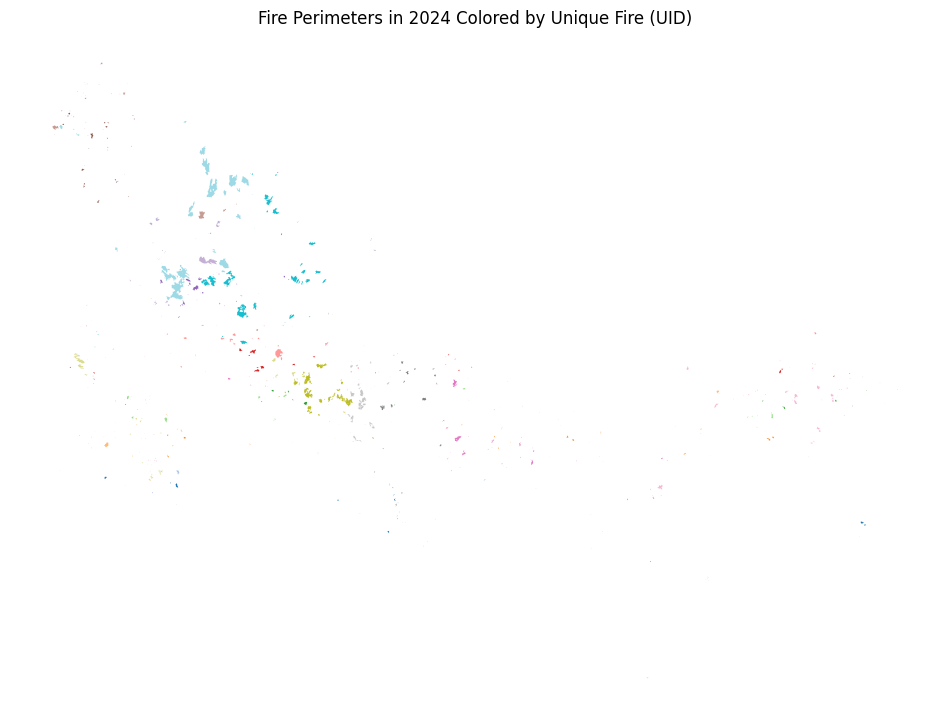

In [85]:
# STEP 1: Assign CRS to fire if missing (most likely WGS84 from FIRMS)
if fire.crs is None:
    fire.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

# STEP 2: Set CRS on cc manually (based on .prj content)
if cc.crs is None:
    cc.set_crs(epsg=3978, inplace=True)  # NAD_1983_Canada_Atlas_Lambert

# STEP 3: Reproject fire to match cc's CRS
fire = fire.to_crs(cc.crs)

# STEP 4: Spatial join — assign each fire point the polygon it intersects
fire_with_cc = gpd.sjoin(fire, cc, how="inner", predicate="intersects")

# Step 5: View join result (check for UID or CONSIS_ID)
print(fire_with_cc.head())

# Count number of fire points per polygon UID
counts = fire_with_cc.groupby("UID").size().reset_index(name="hotspot_count")

# Join counts back to cc dataset
cc_with_counts = cc.merge(counts, on="UID", how="left")
cc_with_counts["hotspot_count"] = cc_with_counts["hotspot_count"].fillna(0).astype(int)

# Plot fire perimeters colored by UID
fig, ax = plt.subplots(figsize=(12, 12))
cc_with_counts.plot(
    ax=ax,
    column="UID",             # Color by fire ID
    categorical=True,
    legend=False,
    cmap="tab20"
)

ax.set_title("Fire Perimeters in 2024 Colored by Unique Fire (UID)")
ax.axis("off")
plt.show()

     LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME  \
291   52.6151  -122.1731       335.6   1.3    1.1 2024-02-13     2147   
553   45.9210   -77.3333       300.3   4.1    1.9 2024-04-02     1743   
559   45.9235   -77.3863       321.6   2.6    1.5 2024-04-02     1920   
561   45.9191   -77.3605       394.9   2.6    1.5 2024-04-02     1920   
581   53.9184  -102.2324       300.3   1.8    1.3 2024-04-07     1932   

    SATELLITE INSTRUMENT  CONFIDENCE  ... DAYNIGHT  TYPE  \
291      Aqua      MODIS          78  ...        D     0   
553      Aqua      MODIS           0  ...        D     0   
559      Aqua      MODIS          61  ...        D     0   
561      Aqua      MODIS         100  ...        D     0   
581      Aqua      MODIS          26  ...        D     0   

                            geometry index_right       UID HCOUNT      AREA  \
291   POINT (-1762826.242 781934.01)         194  32268462     67   534.531   
553      POINT (1370605.463 -152918)      

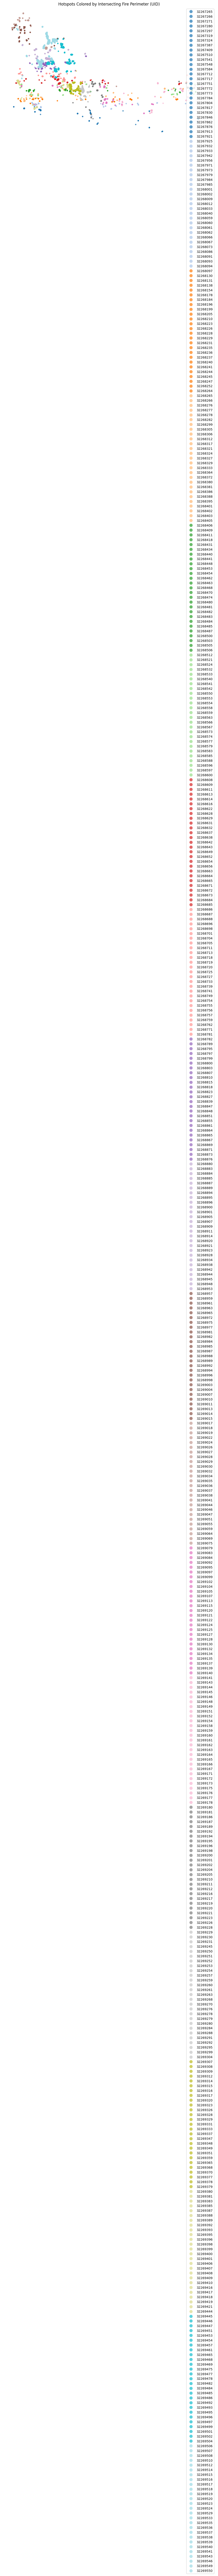

In [86]:
# STEP 1: Assign CRS to fire if missing (most likely WGS84 from FIRMS)
if fire.crs is None:
    fire.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

# Step 2: Set CRS on cc manually (based on .prj content)
if cc.crs is None:
    cc.set_crs(epsg=3978, inplace=True)  # NAD_1983_Canada_Atlas_Lambert

# STEP 3: Reproject fire to match cc's CRS
fire = fire.to_crs(cc.crs)

# STEP 4: Spatial join — assign each fire point the polygon it intersects
fire_with_uid = gpd.sjoin(fire, cc, how="inner", predicate="intersects")

# Step 5: Preview results
print(fire_with_uid.head())

# Plot fire points, colored by intersecting polygon UID
fig, ax = plt.subplots(figsize=(12, 12))

fire_with_uid.plot(
    ax=ax,
    column="UID",          # Color by the fire perimeter UID they intersect
    categorical=True,
    legend=True,
    cmap="tab20",
    markersize=10,
    alpha=0.7
)

ax.set_title("Hotspots Colored by Intersecting Fire Perimeter (UID)")
ax.axis("off")

plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree

# Load data
fire = gpd.read_file("data_2024/hotspots/fire_archive_M-C61_629919.shp")
fire['ACQ_DATE'] = pd.to_datetime(fire['ACQ_DATE'])
fire['day'] = (fire['ACQ_DATE'] - fire['ACQ_DATE'].min()).dt.days

# Sort data by date
fire = fire.sort_values('ACQ_DATE')

# Prepare training data by pairing points day t with points day t+1 nearby (within 5km)
def pair_points_next_day(df, max_distance_km=5):
    earth_radius_km = 6371.0
    pairs = []

    # Precompute radians coords for all points
    coords_rad = np.radians(df[['LATITUDE', 'LONGITUDE']].values)
    
    # Group points by date
    grouped = df.groupby('ACQ_DATE')
    dates = sorted(df['ACQ_DATE'].unique())
    
    for i in range(len(dates)-1):
        day_t = dates[i]
        day_t1 = dates[i+1]
        
        pts_t = df[df['ACQ_DATE'] == day_t]
        pts_t1 = df[df['ACQ_DATE'] == day_t1]
        
        if pts_t.empty or pts_t1.empty:
            continue
        
        tree_t1 = BallTree(np.radians(pts_t1[['LATITUDE', 'LONGITUDE']].values), metric='haversine')
        
        for idx, row in pts_t.iterrows():
            point_rad = np.radians([[row['LATITUDE'], row['LONGITUDE']]])
            radius_rad = max_distance_km / earth_radius_km
            ind = tree_t1.query_radius(point_rad, r=radius_rad)
            neighbors_idx = ind[0]
            
            # If multiple neighbors next day, take closest
            if len(neighbors_idx) > 0:
                neighbors = pts_t1.iloc[neighbors_idx]
                dists = BallTree(np.radians(neighbors[['LATITUDE', 'LONGITUDE']])).query(point_rad, k=len(neighbors))[0][0]
                closest_idx = neighbors_idx[np.argmin(dists)]
                closest_point = pts_t1.iloc[closest_idx]
                
                pairs.append({
                    'lat_t': row['LATITUDE'],
                    'lon_t': row['LONGITUDE'],
                    'frp_t': row['FRP'],
                    'day_t': (day_t - df['ACQ_DATE'].min()).days,
                    'lat_t1': closest_point['LATITUDE'],
                    'lon_t1': closest_point['LONGITUDE']
                })
    return pd.DataFrame(pairs)

train_df = pair_points_next_day(fire)

# Features and targets
X = train_df[['lat_t', 'lon_t', 'frp_t', 'day_t']]
y_lat = train_df['lat_t1']
y_lon = train_df['lon_t1']

# Train/test split
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Train regressors
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, random_state=42)

model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Predict next day locations from test set
lat_pred = model_lat.predict(X_test)
lon_pred = model_lon.predict(X_test)

# Show example predictions
for i in range(5):
    print(f"Current location: ({X_test.iloc[i]['lat_t']:.4f}, {X_test.iloc[i]['lon_t']:.4f})")
    print(f"Actual next day location: ({y_lat_test.iloc[i]:.4f}, {y_lon_test.iloc[i]:.4f})")
    print(f"Predicted next day location: ({lat_pred[i]:.4f}, {lon_pred[i]:.4f})\n")

Current location: (58.7506, -114.8503)
Actual next day location: (58.7097, -114.8500)
Predicted next day location: (58.7450, -114.8543)

Current location: (54.8395, -103.1284)
Actual next day location: (54.8299, -103.1868)
Predicted next day location: (54.8276, -103.1797)

Current location: (65.2529, -124.9639)
Actual next day location: (65.2461, -125.0024)
Predicted next day location: (65.2461, -125.0028)

Current location: (55.9985, -107.4630)
Actual next day location: (55.9923, -107.5321)
Predicted next day location: (55.9893, -107.5285)

Current location: (58.7993, -114.6196)
Actual next day location: (58.7761, -114.6479)
Predicted next day location: (58.7781, -114.6509)



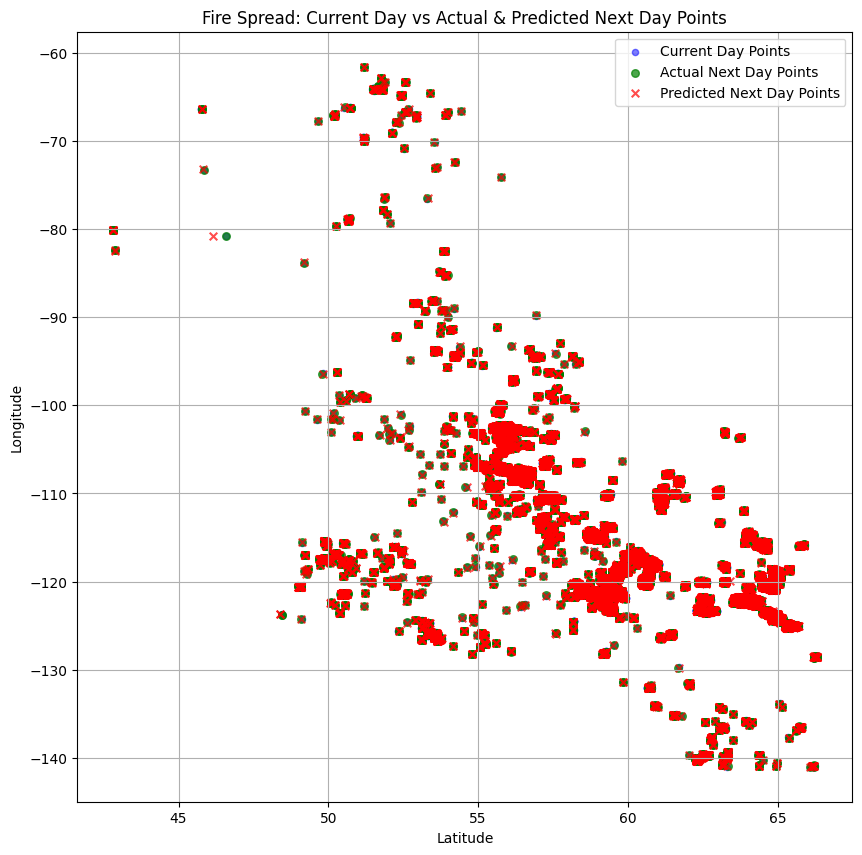

In [94]:
import matplotlib.pyplot as plt

# Plot actual vs predicted next day locations
plt.figure(figsize=(10, 10))

# Plot current day points (X_test locations)
plt.scatter(X_test['lat_t'], X_test['lon_t'], c='blue', label='Current Day Points', alpha=0.5, s=20)

# Plot actual next day points
plt.scatter(y_lat_test, y_lon_test, c='green', label='Actual Next Day Points', alpha=0.7, s=30)

# Plot predicted next day points
plt.scatter(lat_pred, lon_pred, c='red', label='Predicted Next Day Points', alpha=0.7, s=30, marker='x')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Fire Spread: Current Day vs Actual & Predicted Next Day Points')
plt.legend()
plt.grid(True)
plt.show()